<a href="https://colab.research.google.com/github/lunaB/AI-Study/blob/master/6_mnist_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook


torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [0]:
mnist_train = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [3]:
print(mnist_train)
print(mnist_train.data.shape)
print(mnist_train.targets.shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


In [0]:
dataloader = torch.utils.data.DataLoader(mnist_train, 100, shuffle=True, drop_last=True)

In [0]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()

        self.linear1 = nn.Linear(28*28, 512, bias=True)
        self.linear2 = nn.Linear(512, 512, bias=True)
        self.linear3 = nn.Linear(512, 10, bias=True)
        
        self.dropout = nn.Dropout(p = 0.5)
        self.relu = nn.ReLU()
        self.batchNorm1 = nn.BatchNorm1d(512)
        self.batchNorm2 = nn.BatchNorm1d(512)
        # self.batchNorm3 = nn.BatchNorm1d(10)

        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)

        self.layer = nn.Sequential(self.linear1, self.batchNorm1, self.relu, self.dropout,
                                   self.linear2, self.batchNorm2, self.relu, self.dropout,
                                   self.linear3).to(device)

    def forward(self, x):
        return self.layer(x)

In [6]:
model = MnistModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
hist_train = []
hist_test = []
n_epoch = 15
for epoch in tqdm_notebook(range(n_epoch+1)):
    model.train()
    batch_loss = 0
    for idx, mini_batch in enumerate(dataloader):
        x_train, y_train = mini_batch
        x_train = x_train.view(-1,28*28).to(device)
        y_train = y_train.to(device)
        
        pred = model(x_train)

        loss = F.cross_entropy(pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()

    model.eval()
    pred = model(mnist_train.data.view(-1,28*28).float().to(device)).detach()
    hist_train.append((mnist_train.targets.to(device) == torch.argmax(pred, 1)).float().mean().item()*100)
    
    pred = model(mnist_test.data.view(-1,28*28).float().to(device)).detach()
    hist_test.append((mnist_test.targets.to(device) == torch.argmax(pred, 1)).float().mean().item()*100)

    print('epoch :',epoch, 'loss :', batch_loss/len(dataloader), 'train_acc :', hist_train[epoch], 'test_acc :', hist_test[epoch])
    batch_loss = 0

epoch : 0 loss : 0.333838997532924 train_acc : 95.33500075340271 test_acc : 95.08000016212463
epoch : 1 loss : 0.17689553887893755 train_acc : 93.15666556358337 test_acc : 92.35000014305115
epoch : 2 loss : 0.1456819095245252 train_acc : 93.01833510398865 test_acc : 92.32999682426453
epoch : 3 loss : 0.1210873563370357 train_acc : 90.96333384513855 test_acc : 90.04999995231628
epoch : 4 loss : 0.10771522187162191 train_acc : 90.31167030334473 test_acc : 89.46999907493591
epoch : 5 loss : 0.09697451755714913 train_acc : 92.74666905403137 test_acc : 91.94999933242798
epoch : 6 loss : 0.08668062184471637 train_acc : 90.51166772842407 test_acc : 89.98000025749207
epoch : 7 loss : 0.0819584024278447 train_acc : 91.36666655540466 test_acc : 91.06000065803528
epoch : 8 loss : 0.07621132831322029 train_acc : 91.32333397865295 test_acc : 90.70000052452087
epoch : 9 loss : 0.07306048856776517 train_acc : 91.3016676902771 test_acc : 90.1699960231781
epoch : 10 loss : 0.06848594163563879 train_acc

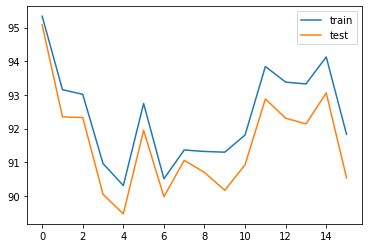

In [7]:
plt.plot(hist_train, label='train')
plt.plot(hist_test, label='test')
le = plt.legend()
plt.show()

tensor(5, device='cuda:0')


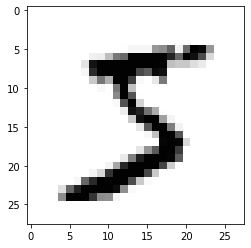

In [8]:
model.eval()
x_train, y_train = dataloader.dataset[0]
data = model(x_train.view(-1, 28*28).to(device)).detach()[0]
print(torch.argmax(data))
plt.imshow(x_train[0], cmap='Greys')
plt.show()

In [9]:
model.eval()
pred = model(mnist_train.data.view(-1,28*28).float().to(device)).detach()
print('Train Accuracy : %.2f%%'%((mnist_train.targets.to(device) == torch.argmax(pred, 1)).float().mean().item()*100))

Train Accuracy : 91.83%


In [10]:
model.eval()
pred = model(mnist_test.data.view(-1,28*28).float().to(device)).detach()
print('Test Accuracy : %.2f%%'%((mnist_test.targets.to(device) == torch.argmax(pred, 1)).float().mean().item()*100))

Test Accuracy : 90.54%
